#Creation of the model

In [54]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import statistics


In [ ]:

avg_len=695  #1118

def make_even2(df, avg_len):
  if(df.shape[0]==avg_len):
    return df
  if (df.shape[0]>avg_len):
    return df.head(avg_len)

  extra_df=df.copy()
  while (extra_df.shape[0]<avg_len):
    extra_df=pd.concat([extra_df, df])
  print(extra_df)
  return extra_df.head(avg_len)

def make_even(df, avg_len):
    data_list = []
    if(df.shape[0]==avg_len):
      return data_list.append(df)
    if df.shape[0] > avg_len:
        start = 0
        end = avg_len
        while end <= df.shape[0]:
            data_list.append(df[start:end])
            start = end
            end += avg_len
        remaining = df[start:]
        if remaining.shape[0] < 0.72 * avg_len:
            return data_list
        else:
            df = remaining

    extra_df = df.copy()
    while extra_df.shape[0] < avg_len:
        extra_df = pd.concat([extra_df, df])
    data_list.append(extra_df.head(avg_len))
    return data_list


def check_run(str):
  if (str=='Running'):
    return 1
  else:
    return 0

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This function above is used to make all segments have consistent length. We found the Average length of the datasets to be approximately 1118 readings. as Such, we used this as our length.

In [ ]:
directory = '/content/drive/MyDrive/data/'
file_list=[]
mean_lenght = []
i =0
extra_array=pd.DataFrame()
for filename in os.listdir(directory):
    i+=1
    file_list.append(filename)
    f = os.path.join(directory, filename)
    # checking if it is a file
    try:
      data = pd.read_csv(f, skiprows = 5)
    except:
      try:
        data.columns = ['Time [sec]'	,'ACC X'	,'ACC Y'	,'ACC Z']
      except:
        data = pd.read_csv(f, skiprows = 4)
    mean_lenght.append(data.shape[0])
print(statistics.mean(mean_lenght))
print(i)

695.3188976377953
254


In [ ]:
min(mean_lenght)

91

In [ ]:
directory = '/content/drive/MyDrive/data/'
extra_array=pd.DataFrame()
def fix_files(directory):
  truth_list=[]
  file_list=[]
  extra_array=pd.DataFrame()
  for filename in os.listdir(directory):
      file_list.append(filename)
      f = os.path.join(directory, filename)
      # checking if it is a file
      label = None
      try:
        data = pd.read_csv(f, skiprows = 5)
        x=data['ACC X']**0.5
      except:
        try:
          data.columns = ['Time [sec]'	,'ACC X'	,'ACC Y'	,'ACC Z']
        except:
          data = pd.read_csv(f, skiprows = 4)
      ####activity_Type###
      """try:
          label=check_run(pd.read_csv(f).loc[1][1])
          truth_list.append(label)
      except:
          label=check_run(pd.read_csv(f, skiprows = 1,on_bad_lines='skip').loc[0][1])
          truth_list.append(label)"""
      #####

      data.columns = ['Time [sec]'	,'ACC X'	,'ACC Y'	,'ACC Z']
      ##
      data = data.apply(pd.to_numeric, errors='coerce')
      # drop rows that contain NaN values
      data = data.dropna()
      ##
      data['peak']=(data['ACC X']**2+data['ACC Y']**2+data['ACC Z']**2)**0.5
      list_data=make_even(data, avg_len)
      #extra_array=pd.concat([extra_array,pd.Series(list_data.T.loc['peak'].to_list())], axis=1)

      for i in range(len(list_data)):
          extra_array=pd.concat([extra_array,pd.Series(list_data[i].T.loc['peak'].to_list())], axis=1)
          try:
              label=check_run(pd.read_csv(f).loc[1][1])
              truth_list.append(label)
          except:
              label=check_run(pd.read_csv(f, skiprows = 1,on_bad_lines='skip').loc[0][1])
              truth_list.append(label)

  extra_array=extra_array.T.reset_index().drop(['index'],axis=1)

  extra_array['truth']=pd.Series(truth_list)
  return extra_array, file_list

extra_array=fix_files(directory)[0]

In [ ]:
extra_array.shape

(276, 696)

In [ ]:
print(extra_array[0])

0       8.643527
1       9.977199
2      10.630699
3      10.969690
4      11.391637
         ...    
271    10.277219
272     9.754824
273    10.138096
274     8.557944
275    10.446248
Name: 0, Length: 276, dtype: float64


Here we basically create our combined dataset. We turn each file into one row of our completed dataset.

In [ ]:
from sklearn.model_selection import train_test_split

X=extra_array.drop(['truth'], axis=1)
y=np.ravel(extra_array['truth'])
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
x_train=x_train.to_numpy()
x_test=x_test.to_numpy()



In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from pickle import dump
from pickle import load

np.random.seed(14)

X_train=x_train
X_train_scaled = x_train

model=RandomForestClassifier(max_depth=5)
model.fit(X_train_scaled, y_train)

########### Saving the
with open('/content/drive/MyDrive/model.pkl', 'wb') as file:
    dump(model, file)
#dump(model, open('/content/drive/MyDrive/data/model.pkl', 'wb'))
################## loading them
#model = load(open('model.pkl', 'rb'))
################# loading our model for testing
#model = load(open('/content/drive/MyDrive/walk_run_model.pkl', 'rb'))

X_test_scaled =x_test
yhat = model.predict(X_test_scaled)

#######################################################################
# evaluate accuracy
acc = accuracy_score(y_test, yhat)
print('Test Accuracy:', acc)
f1=f1_score(y_test, yhat, average='macro')
print ('F1 Score:', f1)
pref=precision_recall_fscore_support(y_test, yhat, average=None,labels=[0,1])
print ('pref:', pref)

seed=14
###Test Accuracy: 0.9107142857142857
###F1 Score: 0.9071310116086236
###pref: (array([0.91176471, 0.90909091]), array([0.93939394, 0.86956522]), array([0.92537313, 0.88888889]), array([33, 23]))

Test Accuracy: 0.9107142857142857
F1 Score: 0.9071310116086236
pref: (array([0.91176471, 0.90909091]), array([0.93939394, 0.86956522]), array([0.92537313, 0.88888889]), array([33, 23]))


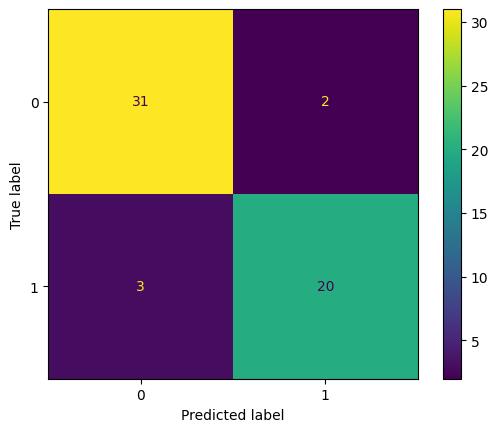

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, yhat)
plt.show()


#Using our ready model

In [51]:
import numpy as np
import pandas as pd
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import scipy
from scipy.signal import find_peaks
drive.mount('/content/drive')
import pandas as pd
from pickle import load
import sys
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from pickle import dump
from pickle import load
import pandas as pd
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.signal import find_peaks
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from pickle import dump
from pickle import load


In [106]:
def replace_outliers_with_mean(column):

    upper = column.quantile(0.99)
    outliers = column[(column > upper)]
    column[outliers.index] = column.mean()

    return column


def normalize(columns_to_normalize, dataframe):

  scaler = MinMaxScaler()
  dataframe[columns_to_normalize] = scaler.fit_transform(dataframe[columns_to_normalize])
  return dataframe


def stat_tenis(coups, preds):

  peaks, _ = find_peaks(coups['ANorm'].values, distance=34/2, height=0.94)
  print("lenpozkcedl",len(peaks))
  nb_de_coup = len(peaks)
  diff = np.diff(peaks)
  echange = [peaks[i]  for i in range(len(diff)) if  diff[i]>34*1.5] #
  nb_echange = len(echange)+11
  nb_arret = len(echange)
  nb_coup_par_echange = []
  if len(echange) > 0:
    for i in range(len(echange)):
      if i == 0:
          pks, _ = find_peaks(coups['ANorm'][0:echange[i]], distance=34/2, height=0.94)
          nb_coup_par_echange.append(len(pks))
      else:
          pks, _ = find_peaks(coups['ANorm'][echange[i-1]:echange[i]], distance=34/2, height=0.94)
          nb_coup_par_echange.append(len(pks))
    print(echange)
    if len(peaks) > 6 and echange[-1]!=peaks[-2]:
      idx = list(peaks).index(echange[-1])
      pks, _ = find_peaks(coups['ANorm'][peaks[idx]:peaks[-1]], distance=34/2, height=0.94)
      nb_coup_par_echange.append(len(pks))
    if len(nb_coup_par_echange) == 0:
        pks, _ = find_peaks(coups['ANorm'], distance=34/2, height=0.94)
        nb_coup_par_echange.append(len(pks))
  else:
    pks, _ = find_peaks(coups['ANorm'], distance=34/2, height=0.94)
    nb_coup_par_echange.append(len(pks))

  moy_coup_par_echange = np.mean(nb_coup_par_echange)
  var_coup_par_echange = np.var(nb_coup_par_echange)
  max_coup_par_echange = max(nb_coup_par_echange)
  min_coup_par_echange = min(nb_coup_par_echange)

  vitesse_basse = []
  vitesse_haute = []
  vitesse_par_echange = []
  v = [0,0]
  ech = 1
  moy_de_coup = 0
  a = 0
  print(len(diff))
  for i in range(len(diff)):

      if diff[i] > 34*1.5:
        vitesse_basse.append(3.6*21/(0.045*diff[i-1]))
        vitesse_haute.append(3.6*26/(0.045*diff[i-1]))
        v[0] = float(v[0]/ech)
        v[1] = float(v[1]/ech)
        vitesse_par_echange.append(v)
        v = [0,0]
        ech = 1
      else:
        vitesse_basse.append(3.6*21/(0.045*diff[i]))
        vitesse_haute.append(3.6*26/(0.045*diff[i]))

      v[0] += 3.6*21/(0.045*diff[i])
      v[1] += 3.6*26/(0.045*diff[i])
      ech +=1


  moyenne_vitesse_basse = np.mean(vitesse_basse)
  moyenne_vitesse_haute = np.mean(vitesse_haute) #qur tous le csv
  max_vitesse_basse = np.max(vitesse_basse)
  max_vitesse_haute = np.max(vitesse_haute)
  moy_vit_h_cd = []
  moy_vit_b_cd = []
  moy_vit_h_rv = []
  moy_vit_B_rv = []
  for i in range(len(vitesse_basse)):
    if preds[i]==0:
      moy_vit_h_cd.append(vitesse_haute[i])
      moy_vit_b_cd.append(vitesse_basse[i])
    else:
      moy_vit_h_rv.append(vitesse_haute[i])
      moy_vit_B_rv.append(vitesse_basse[i])

  nombre_de_cd = list(preds).count(0)
  nombre_de_rv = list(preds).count(1)


  return str(nb_de_coup)+','+str(nombre_de_rv)+','+str(nombre_de_cd)+','+str(var_coup_par_echange)+','+str(max_vitesse_basse)+'-'+str(max_vitesse_haute)+','+str(moyenne_vitesse_basse)+'-'+str(moyenne_vitesse_haute)+','+str(max_coup_par_echange)+','+str(moy_coup_par_echange)



def replace_outliers_with_mean(column):

    upper = column.quantile(0.99)
    outliers = column[(column > upper)]
    column[outliers.index] = column.mean()

    return column

def normalize(columns_to_normalize, dataframe):

  scaler = MinMaxScaler()
  dataframe[columns_to_normalize] = scaler.fit_transform(dataframe[columns_to_normalize])
  return dataframe



def replace_second_one(column):
    indexes = np.nonzero(column.values)[0]
    for i in range(1, len(indexes)):
        if indexes[i] - indexes[i-1] < 15:
            column.at[indexes[i]] = 0
    return column


def create_df(path):

  cd_df = pd.read_csv(path, skiprows=1)
  cd_df.reset_index(drop=True, inplace=True)
  cd_df = cd_df.apply(pd.to_numeric, errors='coerce')
  replace_outliers_with_mean

  for col in list(cd_df.columns):
      cd_df[col]  = replace_outliers_with_mean(cd_df[col])

  cd_df = normalize(list(cd_df.columns),cd_df)
  #cd_df = cd_df.fillna(cd_df.mean())
  cd_df = cd_df.interpolate()

  return cd_df



def make_even(df):
    avg_len=695
    data_list = []
    if(df.shape[0]==avg_len):
      return data_list.append(df)
    if df.shape[0] > avg_len:
        start = 0
        end = avg_len
        while end <= df.shape[0]:
            data_list.append(df[start:end])
            start = end
            end += avg_len
        remaining = df[start:]
        if remaining.shape[0] < 0.72 * avg_len:
            return data_list
        else:
            df = remaining

    extra_df = df.copy()
    while extra_df.shape[0] < avg_len:
        extra_df = pd.concat([extra_df, df])
    data_list.append(extra_df.head(avg_len))
    return data_list


def check_run(str):
  if (str=='Running'):
    return 1
  else:
    return 0

def predict_coupdroit(df):
  model = load(open('/content/drive/MyDrive/model_tenis.pkl', 'rb'))

  cps = df
  peaks, _ = find_peaks(cps['ANorm'].values, distance=34/2, height=0.94)
  middle = []
  l=[]
  data = []
  print(peaks)
  for j in range(0, len(peaks)):
    if peaks[j]-6<1:
      continue
    l= list(cps['Mx'][peaks[j]-6:peaks[j]].values)
    l.extend(list(cps['My'][peaks[j]-6:peaks[j]].values))
    l.extend(list(cps['Mz'][peaks[j]-6:peaks[j]].values))
    l.extend(list(cps['Gx'][peaks[j]-6:peaks[j]].values))
    l.extend(list(cps['Gy'][peaks[j]-6:peaks[j]].values))
    l.extend(list(cps['Gz'][peaks[j]-6:peaks[j]].values))
    data.append(l)
  column_names = [i for i in range(36)]

  array = np.stack(data)
  df = pd.DataFrame(array,columns=column_names)
  df =df.dropna()
  preds = model.predict(df)
  return preds


def predict_running(df):

    extra_array=pd.DataFrame()
    model = load(open('/content/drive/MyDrive/model_running.pkl', 'rb'))


    data = df
    #data = pd.read_csv(path_csv, skiprows = 1)

    data['peak']= data['ANorm']
    list_data=make_even(data)
    for i in range(len(list_data)):
          extra_array=pd.concat([extra_array,pd.Series(list_data[i].T.loc['peak'].to_list())], axis=1)
    extra_array=extra_array.T.reset_index().drop(['index'],axis=1)
    X_test=extra_array
    yhat = model.predict(X_test)
    preds=list(map(str, yhat) )
    for indexa, yi in enumerate(yhat):
        if yi ==1:
            preds[indexa] = 'Running'
        else:
            preds[indexa] = 'Walking'
    return preds[0]



In [72]:
#!/usr/bin/python




#predict_running('/content/memory.csv')




In [107]:
def main():
  path_csv = '/content/memory.csv'
  first_row = pd.read_csv(path_csv, nrows=1)
  df = create_df(path_csv)
  length = len(df['ANorm'])
  if list(first_row.columns)[0] == 'run':
    prediction = predict_running(df)
    distance = 0
    nombredepas= 0
    vit = 0

    if prediction == 'Walking':
        """min_value = df['ANorm'].min()
        max_value = df['ANorm'].max()
        df['ANorm'] = (df['ANorm'] - min_value) / (max_value - min_value)"""

        peaks, _ = find_peaks(df['ANorm'].values, distance=6, height=0.6)
        nombre_de_pas = len(peaks)
        distance = nombre_de_pas *0.8

        vitesse = (3.6*distance)/(0.045*length)
    else:
        peaks, _ = find_peaks(df['ANorm'].values, distance=1, height=0.6)
        nombre_de_pas = len(peaks)
        distance = nombre_de_pas *1.1
    return str(prediction)+','+str(vitesse)+','+str(nombre_de_pas)+',',distance
  else:
    preds = predict_coupdroit(df)
    return stat_tenis(df,preds)



main()

[  1  29  51  71  91 108 125 143]
lenpozkcedl 8
7


'8,7,0,0.0,98.82352941176471-122.3529411764706,85.04914693149988-105.29894381995223,8,8.0'

In [90]:
df = pd.read_csv('/content/memory.csv', skiprows=1)

mean_values = df.mean()
mean_values

Time     767.019603
Ax         0.468382
Ay         9.250530
Az        -0.331457
Gx         1.474834
Gy        37.089073
Gz         6.269379
Mx        16.216933
My       -18.368212
Mz       -23.061523
ANorm      6.705960
GNorm      1.072848
MNorm     35.167086
dtype: float64

#Using our ready model

In [ ]:
import numpy as np
import pandas as pd
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import scipy
from scipy.signal import find_peaks
drive.mount('/content/drive')
import pandas as pd
from pickle import load
import sys
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from pickle import dump
from pickle import load
import pandas as pd
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.signal import find_peaks
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from pickle import dump
from pickle import load


In [ ]:
def replace_outliers_with_mean(column):

    upper = column.quantile(0.99)
    outliers = column[(column > upper)]
    column[outliers.index] = column.mean()

    return column


def normalize(columns_to_normalize, dataframe):

  scaler = MinMaxScaler()
  dataframe[columns_to_normalize] = scaler.fit_transform(dataframe[columns_to_normalize])
  return dataframe


def stat_tenis(coups, preds):

  peaks, _ = find_peaks(coups['ANorm'].values, distance=34/2, height=0.94)
  print("lenpozkcedl",len(peaks))
  nb_de_coup = len(peaks)
  diff = np.diff(peaks)
  echange = [peaks[i]  for i in range(len(diff)) if  diff[i]>34*1.5] #
  nb_echange = len(echange)+11
  nb_arret = len(echange)
  nb_coup_par_echange = []
  if len(echange) > 0:
    for i in range(len(echange)):
      if i == 0:
          pks, _ = find_peaks(coups['ANorm'][0:echange[i]], distance=34/2, height=0.94)
          nb_coup_par_echange.append(len(pks))
      else:
          pks, _ = find_peaks(coups['ANorm'][echange[i-1]:echange[i]], distance=34/2, height=0.94)
          nb_coup_par_echange.append(len(pks))
    print(echange)
    if len(peaks) > 6 and echange[-1]!=peaks[-2]:
      idx = list(peaks).index(echange[-1])
      pks, _ = find_peaks(coups['ANorm'][peaks[idx]:peaks[-1]], distance=34/2, height=0.94)
      nb_coup_par_echange.append(len(pks))
    if len(nb_coup_par_echange) == 0:
        pks, _ = find_peaks(coups['ANorm'], distance=34/2, height=0.94)
        nb_coup_par_echange.append(len(pks))
  else:
    pks, _ = find_peaks(coups['ANorm'], distance=34/2, height=0.94)
    nb_coup_par_echange.append(len(pks))

  moy_coup_par_echange = np.mean(nb_coup_par_echange)
  var_coup_par_echange = np.var(nb_coup_par_echange)
  max_coup_par_echange = max(nb_coup_par_echange)
  min_coup_par_echange = min(nb_coup_par_echange)

  vitesse_basse = []
  vitesse_haute = []
  vitesse_par_echange = []
  v = [0,0]
  ech = 1
  moy_de_coup = 0
  a = 0
  print(len(diff))
  for i in range(len(diff)):

      if diff[i] > 34*1.5:
        vitesse_basse.append(3.6*21/(0.045*diff[i-1]))
        vitesse_haute.append(3.6*26/(0.045*diff[i-1]))
        v[0] = float(v[0]/ech)
        v[1] = float(v[1]/ech)
        vitesse_par_echange.append(v)
        v = [0,0]
        ech = 1
      else:
        vitesse_basse.append(3.6*21/(0.045*diff[i]))
        vitesse_haute.append(3.6*26/(0.045*diff[i]))

      v[0] += 3.6*21/(0.045*diff[i])
      v[1] += 3.6*26/(0.045*diff[i])
      ech +=1


  moyenne_vitesse_basse = np.mean(vitesse_basse)
  moyenne_vitesse_haute = np.mean(vitesse_haute) #qur tous le csv
  max_vitesse_basse = np.max(vitesse_basse)
  max_vitesse_haute = np.max(vitesse_haute)
  moy_vit_h_cd = []
  moy_vit_b_cd = []
  moy_vit_h_rv = []
  moy_vit_B_rv = []
  for i in range(len(vitesse_basse)):
    if preds[i]==0:
      moy_vit_h_cd.append(vitesse_haute[i])
      moy_vit_b_cd.append(vitesse_basse[i])
    else:
      moy_vit_h_rv.append(vitesse_haute[i])
      moy_vit_B_rv.append(vitesse_basse[i])

  nombre_de_cd = list(preds).count(0)
  nombre_de_rv = list(preds).count(1)


  return str(nb_de_coup)+','+str(nombre_de_rv)+','+str(nombre_de_cd)+','+str(var_coup_par_echange)+','+str(max_vitesse_basse)+'-'+str(max_vitesse_haute)+','+str(moyenne_vitesse_basse)+'-'+str(moyenne_vitesse_haute)+','+str(max_coup_par_echange)+','+str(moy_coup_par_echange)



def replace_outliers_with_mean(column):

    upper = column.quantile(0.99)
    outliers = column[(column > upper)]
    column[outliers.index] = column.mean()

    return column

def normalize(columns_to_normalize, dataframe):

  scaler = MinMaxScaler()
  dataframe[columns_to_normalize] = scaler.fit_transform(dataframe[columns_to_normalize])
  return dataframe



def replace_second_one(column):
    indexes = np.nonzero(column.values)[0]
    for i in range(1, len(indexes)):
        if indexes[i] - indexes[i-1] < 15:
            column.at[indexes[i]] = 0
    return column


def create_df(path):

  cd_df = pd.read_csv(path, skiprows=1)
  cd_df.reset_index(drop=True, inplace=True)
  cd_df = cd_df.apply(pd.to_numeric, errors='coerce')
  replace_outliers_with_mean

  for col in list(cd_df.columns):
      cd_df[col]  = replace_outliers_with_mean(cd_df[col])

  cd_df = normalize(list(cd_df.columns),cd_df)
  #cd_df = cd_df.fillna(cd_df.mean())
  cd_df = cd_df.interpolate()

  return cd_df



def make_even(df):
    avg_len=695
    data_list = []
    if(df.shape[0]==avg_len):
      return data_list.append(df)
    if df.shape[0] > avg_len:
        start = 0
        end = avg_len
        while end <= df.shape[0]:
            data_list.append(df[start:end])
            start = end
            end += avg_len
        remaining = df[start:]
        if remaining.shape[0] < 0.72 * avg_len:
            return data_list
        else:
            df = remaining

    extra_df = df.copy()
    while extra_df.shape[0] < avg_len:
        extra_df = pd.concat([extra_df, df])
    data_list.append(extra_df.head(avg_len))
    return data_list


def check_run(str):
  if (str=='Running'):
    return 1
  else:
    return 0

def predict_coupdroit(df):
  model = load(open('/content/drive/MyDrive/model_tenis.pkl', 'rb'))

  cps = df
  peaks, _ = find_peaks(cps['ANorm'].values, distance=34/2, height=0.94)
  middle = []
  l=[]
  data = []
  print(peaks)
  for j in range(0, len(peaks)):
    if peaks[j]-6<1:
      continue
    l= list(cps['Mx'][peaks[j]-6:peaks[j]].values)
    l.extend(list(cps['My'][peaks[j]-6:peaks[j]].values))
    l.extend(list(cps['Mz'][peaks[j]-6:peaks[j]].values))
    l.extend(list(cps['Gx'][peaks[j]-6:peaks[j]].values))
    l.extend(list(cps['Gy'][peaks[j]-6:peaks[j]].values))
    l.extend(list(cps['Gz'][peaks[j]-6:peaks[j]].values))
    data.append(l)
  column_names = [i for i in range(36)]

  array = np.stack(data)
  df = pd.DataFrame(array,columns=column_names)
  df =df.dropna()
  preds = model.predict(df)
  return preds


def predict_running(df):

    extra_array=pd.DataFrame()
    model = load(open('/content/drive/MyDrive/model_running.pkl', 'rb'))


    data = df
    #data = pd.read_csv(path_csv, skiprows = 1)

    data['peak']= data['ANorm']
    list_data=make_even(data)
    for i in range(len(list_data)):
          extra_array=pd.concat([extra_array,pd.Series(list_data[i].T.loc['peak'].to_list())], axis=1)
    extra_array=extra_array.T.reset_index().drop(['index'],axis=1)
    X_test=extra_array
    yhat = model.predict(X_test)
    preds=list(map(str, yhat) )
    for indexa, yi in enumerate(yhat):
        if yi ==1:
            preds[indexa] = 'Running'
        else:
            preds[indexa] = 'Walking'
    return preds[0]



In [ ]:
#!/usr/bin/python




#predict_running('/content/memory.csv')




In [ ]:
def main():
  path_csv = '/content/memory.csv'
  first_row = pd.read_csv(path_csv, nrows=1)
  df = create_df(path_csv)
  length = len(df['ANorm'])
  if list(first_row.columns)[0] == 'run':
    prediction = predict_running(df)
    distance = 0
    nombredepas= 0
    vit = 0

    if prediction == 'Walking':
        """min_value = df['ANorm'].min()
        max_value = df['ANorm'].max()
        df['ANorm'] = (df['ANorm'] - min_value) / (max_value - min_value)"""

        peaks, _ = find_peaks(df['ANorm'].values, distance=6, height=0.6)
        nombre_de_pas = len(peaks)
        distance = nombre_de_pas *0.8

        vitesse = (3.6*distance)/(0.045*length)
    else:
        peaks, _ = find_peaks(df['ANorm'].values, distance=1, height=0.6)
        nombre_de_pas = len(peaks)
        distance = nombre_de_pas *1.1
    return str(prediction)+','+str(vitesse)+','+str(nombre_de_pas)+',',distance
  else:
    preds = predict_coupdroit(df)
    return stat_tenis(df,preds)



main()

[  1  29  51  71  91 108 125 143]
lenpozkcedl 8
7


'8,7,0,0.0,98.82352941176471-122.3529411764706,85.04914693149988-105.29894381995223,8,8.0'

In [ ]:
df = pd.read_csv('/content/memory.csv', skiprows=1)

mean_values = df.mean()
mean_values

Time     767.019603
Ax         0.468382
Ay         9.250530
Az        -0.331457
Gx         1.474834
Gy        37.089073
Gz         6.269379
Mx        16.216933
My       -18.368212
Mz       -23.061523
ANorm      6.705960
GNorm      1.072848
MNorm     35.167086
dtype: float64